In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/VAST/user_study/evaluation_study/transcription_and_analysis/"
# user study logs
box_path = "/Users/dorislee/Box/viz-summarization-user-study-material/" 

In [4]:
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

# Participant Demographics 

In [236]:
years_of_experience=[1,2,1]

In [238]:
# years_of_experience.hist()

# Interested Retrieval

In [144]:
retreival = pd.read_csv("user_click_data.csv")

In [114]:
from tabulate import tabulate

In [204]:
import tabulate as T
del(T.LATEX_ESCAPE_RULES[u'\\'])

Equal weighting for interested + uninterested, 0 for no selection

In [151]:
def getDataset(x):
    if 'A' in x:
        return "Police"
    else:
        return "Autism"

In [153]:
retreival["dataset"]=retreival["task"].apply(getDataset)

In [170]:
retreival.loc[retreival["interested"]=="unselected","retreival score"]=0
retreival.loc[retreival["interested"]=="interested","retreival score"]=1
retreival.loc[retreival["interested"]=="not interested","retreival score"]=-1
# retreival score, the higher the better, kind of like a relevance score
relevance = retreival.groupby(["dataset","visualization"]).sum()["retreival score"].reset_index().rename(columns={"retreival score":"relevance score"})
retreival = retreival.merge(relevance)
retreival["result score"]=retreival["retreival score"]*retreival["relevance score"]

In [181]:
avrg_result = retreival.groupby(["dataset","task"]).sum()["result score"]

In [192]:
avrg_score_result = [["Police"]+list(avrg_result["Police"]),["Autism"]+list(avrg_result["Autism"])]

In [212]:
print T.tabulate(avrg_score_result,headers=['Dataset','\system','Cluster','BFS'],tablefmt='latex')

\begin{tabular}{lrrr}
\hline
 Dataset   &   \system &   Cluster &   BFS \\
\hline
 Police    &        49 &        20 &    48 \\
 Autism    &       169 &       101 &    46 \\
\hline
\end{tabular}


#### P@k, R@k: say that we only care about top-k retreival

In [24]:
def compute_average_PR_at_k_over_all_data(k):
    retreival["dataset"]=retreival["task"].apply(lambda x:x[0])#.groupby["ideal retreival score"]
    dedup_retreival=retreival[["dataset","visualization","ideal retreival score"]].drop_duplicates()
    
    # get top-k for dataset A and dataset B
    dedup_retreivalA=dedup_retreival[dedup_retreival["dataset"]=='A']
    topk_A = dedup_retreivalA.loc[dedup_retreivalA["ideal retreival score"].nlargest(k,"ideal retreival score").index]
    dedup_retreivalB=dedup_retreival[dedup_retreival["dataset"]=='B']
    topk_B = dedup_retreivalB.loc[dedup_retreivalB["ideal retreival score"].nlargest(k,"ideal retreival score").index]
    topk_A_lst =list(topk_A["visualization"])
    topk_B_lst =list(topk_B["visualization"])
    def compute_PR_at_k(user_id):
        selected_user = retreival[retreival["user"]==user_id]
        relevant = (selected_user["visualization"].isin(topk_A_lst)|selected_user["visualization"].isin(topk_B_lst))
        retreived = (selected_user["interested"]=="interested")
        Nrelevant_and_retreived = float(len(selected_user[(relevant)&(retreived)]))
        Nrelevant = len(selected_user[relevant])
        Nretreived = len(selected_user[retreived])
        if Nrelevant !=0 and Nretreived!=0:
            precision  = Nrelevant_and_retreived/Nrelevant
            recall = Nrelevant_and_retreived/Nretreived
            return precision,recall
        else:
            return 0,0
    # compute PR
    retreival["P@"+str(k)],retreival["R@"+str(k)] = zip(*retreival["user"].apply(compute_PR_at_k))
    return retreival.groupby("task",as_index=False)[["P@"+str(k),"R@"+str(k)]].mean()

In [98]:
compute_average_PR_at_k_over_all_data(5)

,task,P@5,R@5
0,A1,0.564935,0.489286
1,A2,0.933333,0.833333
2,A3,0.702338,0.925000
3,B1,0.844527,0.946429
4,B2,0.430909,0.618333
5,B3,0.833333,0.555556


# Ranking

In [199]:
def dcg(r, k, method=0):
    # alternative formulation of DCG places stronger emphasis on retrieving relevant documents
    r = np.asfarray(r)[:k]
    val = 0
    for i in range(1,len(r)):
        val+= (2**r[i]-1) / np.log2(i+1)
    return val

def ndcg(dcg_ground_truth,r, k):
    return dcg(r, k) / sum(dcg_ground_truth)

In [200]:
def compute_ndcg_rankings(user_ranking_filename,gt_ranking_filename,k_lst = [1,2,3,5,7]):
    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    ground_truth_cramerV_rank = list(ground_truth_rank["cramerV"].rank(ascending=False)) 
    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        user_rankings.append([task,ranking])
    #Computing ndcg ranking
    ndcg_data = []
    for trial in user_rankings:
        ndcg_d = []
        #print trial
        ndcg_d.append(trial[0])
        for k in k_lst:
            ndcg_d.append(ndcg(ground_truth_cramerV_rank,trial[1],k))
#             print trial[1]
        ndcg_data.append(ndcg_d)
#    print ndcg_data
    NDCG_lst = ["NDCG@"+str(k) for k in k_lst]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task"]+NDCG_lst)
    return ndcg_result.groupby("Task",as_index=False).mean()

In [201]:
ndcg_result=[["Police"]+list(compute_ndcg_rankings("Ranking(Police).csv","ct_police_ground_truth_correlation.csv",k_lst=[10])["NDCG@10"]),
["Autism"]+list(compute_ndcg_rankings("Ranking(Autism).csv","autism_ground_truth_correlation.csv",k_lst=[10])["NDCG@10"])]

In [210]:
print T.tabulate(ndcg_result,headers=['Dataset','\system','Cluster','BFS'],tablefmt='latex', floatfmt=".2f")

\begin{tabular}{lrrr}
\hline
 Dataset   &   \system &   Cluster &   BFS \\
\hline
 Police    &      0.63 &      0.45 &  0.84 \\
 Autism    &      0.50 &      0.30 &  0.24 \\
\hline
\end{tabular}


- NDCG@1 is 0 because if the first-ranked attribute is not retreived, then score would be 0.
- This makes sense, our algo does better than kmeans (2) and level-wise BFS (3), except for NDCG@3 A2 for some reason did very well.
- NDCG should be @10 because all users read through and ranked all 10 dashboards.

# Prediction

In [56]:
prediction_ground_truth = {
    'Police1': [55.1,4.2,40.7], #ticket,warn,arrest
    'Police2': [53.43,12.02,34.55], #ticket,warn,arrest
    'Autism1': [17.3,82.7], #NO,YES   
    'Autism2': [41,59] #NO,YES   
}

In [57]:
def euclidean_dist(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt(np.sum(((x-y)**2)))

In [58]:
def compute_prediction_distances(filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    
    #Computing Euclidean Distance
    dist_data = []
    for row in prediction.iterrows():
        user_prediction  = row[1][attributes].values
        gt_prediction = prediction_ground_truth[gt_task_key]
        dist_data.append([row[1][task_name],euclidean_dist(user_prediction,gt_prediction)])
    dist_result = pd.DataFrame(dist_data,columns=["Task","Distance"])
    dist_result.groupby("Task",as_index=False)
    #mean and standard deviation
    distance_aggregate_result = dist_result.groupby("Task",as_index=False)["Distance"].mean()
    distance_aggregate_result["SD"] = dist_result.groupby("Task",as_index=False)["Distance"].apply(lambda x: x.std())
    return distance_aggregate_result

In [83]:
prediction = pd.read_csv(gdrive_path+"Prediction1(Police).csv")

In [59]:
compute_prediction_distances("Prediction1(Police).csv","Police1")

,Task,Distance,SD
0,A1,9.687562,6.465089
1,A2,37.566882,16.323091
2,A3,52.202478,28.153713


In [60]:
compute_prediction_distances("Prediction2(Police).csv","Police2")

,Task,Distance,SD
0,A1,10.138272,4.116052
1,A2,11.607803,4.966252
2,A3,30.708144,36.935642


In [61]:
compute_prediction_distances("Prediction1(Autism).csv","Autism1")

,Task,Distance,SD
0,B1,8.438141,8.628634
1,B2,14.905811,25.426286
2,B3,48.813938,5.960145


In [62]:
compute_prediction_distances("Prediction2(Autism).csv","Autism2")

,Task,Distance,SD
0,B1,26.280802,15.036068
1,B2,19.233304,14.057027
2,B3,16.499158,9.784341


In [221]:
%load_ext autoreload
%autoreload 2
from paper_visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


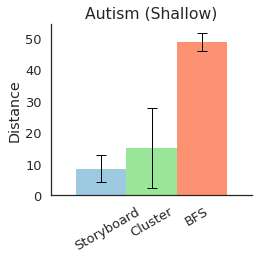

In [239]:
result = compute_prediction_distances("Prediction1(Autism).csv","Autism1")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Autism (Shallow)",
          yErrs=list(result["SD"].values/2.), ytitle="Distance", fixed_ylim=False, rotation=30,
          autolabel_flag =False, filename="Autism1")

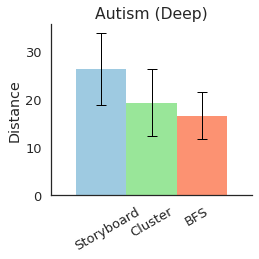

In [240]:
result = compute_prediction_distances("Prediction2(Autism).csv","Autism2")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Autism (Deep)",
          yErrs=list(result["SD"].values/2.), ytitle="Distance",fixed_ylim=False, rotation=30,
          autolabel_flag =False, filename="Autism2")

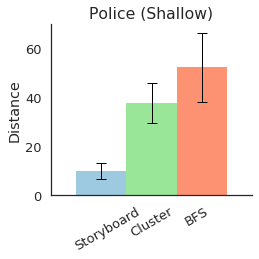

In [241]:
result = compute_prediction_distances("Prediction1(Police).csv","Police1")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Police (Shallow)",
          yErrs=list(result["SD"].values/2.), ytitle="Distance"
          ,fixed_ylim=False , filename="Police1",autolabel_flag=False, rotation=30)

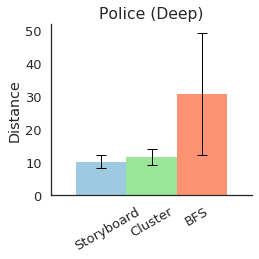

In [242]:
result = compute_prediction_distances("Prediction2(Police).csv","Police2")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Police (Deep)",
          yErrs=list(result["SD"].values/2.), ytitle="Distance", rotation=30,fixed_ylim=False,
          filename="Police2",autolabel_flag=False)

In [243]:
def compute_prediction_aggregate_stats(title,filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    prediction_groupby=prediction.groupby(task_name)

    result = prediction_groupby.mean().reset_index()
    std_result = prediction_groupby.apply(lambda x: x.std()).reset_index()
    return result,std_result

In [77]:
def plot_prediction_results(result,std_result,xtitle="", ytitle="", title="", top_right_text="", N=1, width=0.1,autolabel_flag =True,fixed_ylim=False):
    task_name = ""
    fig, ax = plt.subplots()
    col = 0
    x0_lst =[]
    if "Police" in title: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    labels = result[task_name].values
    for attr in attributes:
        ind = np.arange(N)  # the x locations for the groups
        x0= (col)*(ind + (2+0.5) * width + 0.1)
        x0_lst.append(x0[0])
        yVals = result[attr].values
        xAttrs = attributes
        yErrs = std_result[attr].values/2.

        if len(yVals)==2:
            colors = ["#fc9272","#9ecae1"]
            sns.set_palette(sns.color_palette(colors))
        else:
            colors = ["#9ecae1","#99e699","#fc9272"]
            sns.set_palette(sns.color_palette(colors))

        rects = []
        error_kw=dict(lw=1, capsize=5, capthick=1)
        for i in range(len(yVals)):
            if col==0:
                if yErrs==[]:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width,label=labels[i])
                else:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw,label=labels[i])
            else:
                if yErrs==[]:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width)
                else:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw)
            rects.append(rect)

        xtitle = xtitle.replace('"', '')
        ytitle = ytitle.replace('"', '')

        ax.set_xlabel(xtitle)
        ax.set_ylabel(ytitle)
        if title != "":
            title = title.replace('"','')
            title = title.replace("#", ",\n")
            if title[0] == ',':
                title = title[2:-2]
            if title.count(',') < 3:
                ax.set_title(title)
            else:
                ax.set_title(title)
        xmin = -0.05
        xmax = 0.25 + 0.1 * (len(yVals) - 2)
        xtickpos = [np.abs(xmin - xmax) / (len(yVals) + 1.5) * (i + 0.7) for i in range(len(yVals))]
        if "Police" in title: 
            xtickpos=[0.15,0.51,0.83]
        else: 
            xtickpos=[0.14,0.48]
        ax.set_xticks(xtickpos)
        ax.set_xticklabels(xAttrs)

        if fixed_ylim: ax.set_ylim((0, 100))
        size = 0
        for rect in rects:
            size += 1
        sns.despine(top=True, right=True)
        col+=1
    for col_i in range(len(attributes)):
        if "Police" in title: 
            if col_i==0:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1*width,xtickpos[col_i]+1.5*width, linestyle=":",linewidth=2, color='r',label="ground truth")
            else:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1.5*width,xtickpos[col_i]+1.25*width, linestyle=":",linewidth=2, color='r')
        else:
            if col_i==0:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-0.8*width,xtickpos[col_i]+3.3*width, linestyle=":",linewidth=2, color='r',label="ground truth")
            else:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]+0.5*width,xtickpos[col_i]+4.8*width, linestyle=":",linewidth=2, color='r')

    plt.tight_layout()
    plt.ylabel(ytitle)
    lgd = plt.legend(numpoints=1, loc="center right", bbox_to_anchor=(1.8, 0.5))
    plt.savefig("{}.pdf".format(title), bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.show()

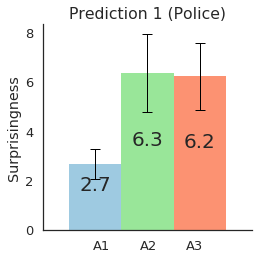

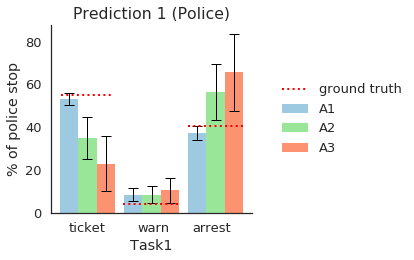

In [79]:
title="Prediction 1 (Police)"
filename = "Prediction1(Police).csv"
gt_task_key="Police1"
task_name = 'Task1'
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,task_name,title=title,ytitle="% of police stop")

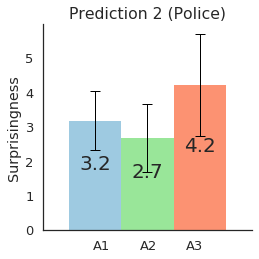

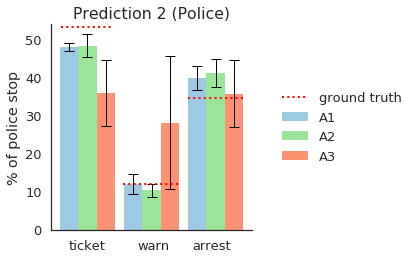

In [80]:
title="Prediction 2 (Police)"
filename = "Prediction2(Police).csv"
gt_task_key="Police2"
task_name = "Task1"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title,ytitle="% of police stop")

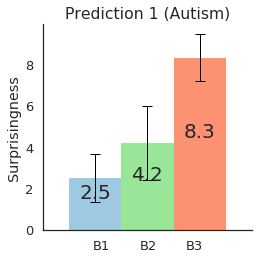

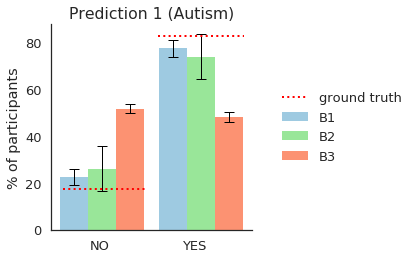

In [81]:
title="Prediction 1 (Autism)"
filename = "Prediction1(Autism).csv"
gt_task_key="Autism1"
task_name = "Task2"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title,ytitle="% of participants")

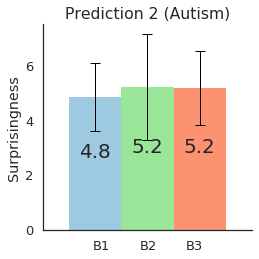

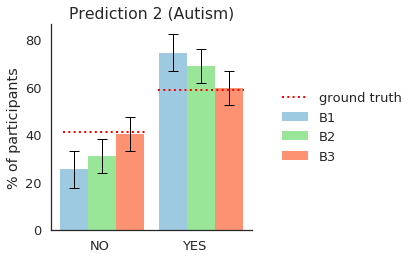

In [82]:
title="Prediction 2 (Autism)"
filename = "Prediction2(Autism).csv"
gt_task_key="Autism2"
task_name = "Task2"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title,ytitle="% of participants")